In [1]:
print('kernel is live')

kernel is live


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from dowhy import CausalModel

pd.options.display.max_colwidth = 1000
pd.options.display.float_format = lambda x: '{x:.2g}'.format(x=x)
pd.options.mode.chained_assignment = None

In [3]:
from data_cleaning_tools import (smooth_data, make_df_monotonic, get_per_capita, 
                                 get_neighbor_mean, get_dxdts, get_tlags, 
                                 interpolate_column, weighted_mean)

# 0. load data

In [4]:
mcmc_pickle_filepath = 'mcmc_res.pickle'
mcmc_data_filepath = 'mcmc_res_data_df.parquet'

In [5]:
import arviz as az #for reformatting the posteriors data into clean xarrays
def SIRVA_model(df, null=False): #dummy function to allow loading the pickle below.
    return

In [6]:
#retrieve estimates of A

#load MCMC posteriors
with open(mcmc_pickle_filepath, "rb") as f:
    posteriors = az.from_numpyro(pickle.load(f))['posterior'] 
    
#get A posteriors means and attach relevant FIPS and dates
A_df = pd.read_parquet(mcmc_data_filepath)[['date','FIPS']]
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.sort_values(['FIPS','date']).reset_index(drop=True)

#fill in missing dates
dates = pd.read_parquet('time_series_df.parquet')[['date','FIPS']]
dates = dates[dates['date']>=A_df['date'].min()]
dates = dates[dates['date']<=A_df['date'].max()]
dates = dates[dates['FIPS'].isin(A_df['FIPS'].unique())].sort_values(['FIPS','date'])
A_df = dates.merge(A_df, on=['FIPS','date'], how='left')

#interpolate A to find values on missing dates
A_df = interpolate_column(A_df, 'A')

A_df

,date,FIPS,A
0,2021-02-06,1005,0.62
1,2021-02-07,1005,0.62
2,2021-02-08,1005,0.62
3,2021-02-09,1005,0.63
4,2021-02-10,1005,0.63
...,...,...,...
73995,2021-08-05,56025,0.83
73996,2021-08-06,56025,0.83
73997,2021-08-07,56025,0.83
73998,2021-08-08,56025,0.83


In [7]:
confounders = ['RepublicanPct2020', 'RUCC_2013', 'Under18Pct2010', 'Age65AndOlderPct2010', 'Ed5CollegePlusPct','GiniCoeff',
               'PopDensity2010_log', 'BlackNonHispanicPct2010_log', 'HispanicPct2010_log', 
               'AsianNonHispanicPct2010_log', 'MedHHInc_log', 'WhiteNonHispanicPct2010_neglog', 
               'n_tweets_all_time_per_capita_log'] # this list of features can be tested as possible confounding variables


def get_data_and_infered_A(smooth_window=None, smooth_order = 1, 
             force_monotonic=True, lags_depth=8):
    
    #load data
    df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
    raw_cols = ['cumulative_vaccinations', 'cumulative_cases', 'cumulative_deaths', 
                'cumulative_antivax_tweets']
    for col in raw_cols: df = df[~df[col].isna()] #filter out any nan data.  this means texas, which has no vax data
    
    #make monotonic and smooth data
    for col in raw_cols: df[col] = df[col].astype(float)
    if smooth_window is not None: df = smooth_data(df, cols = raw_cols, drop_ends=True,
                                                   window_size=smooth_window, order=smooth_order)
    if force_monotonic: df = make_df_monotonic(df, cols=raw_cols, epsilon=1e-5)
         
    #add time step variable
    t = pd.Series(df['date'].unique()).sort_values().reset_index(drop=True).reset_index().rename(columns={'index':'t',0:'date'})
    df = df.merge(right= t , on ='date', how = 'left')

    #compute key variables
    df['N'] = df['population']
    df['V'] = df['cumulative_vaccinations'] #TODO: go back to non-percapita
    df['D'] = df['cumulative_deaths']
    df['C'] = df['cumulative_cases']
    df = get_tlags(df, cols = ['C'], lags = [8])
    df['R'] = df['C_tlag8'] #on average deaths occur 8 days after positive test; contagion typically wanes around the same time for those who dont die
    df = df.drop(columns=['C_tlag8'])
    df['I'] = df['C'] - df['R'] 
    df['S'] = df['N'] - (df['C']+df['V'])
    df['T_a'] = df['cumulative_antivax_tweets']
    df['E'] = get_neighbor_mean(df, ['T_a'], # E = estimated exposure to antivax tweets
                                  neighbor_type = 'retweet', # could also be 'geo', but here is retweet
                                  normalize_edgelist=True
                                  )['T_a_retweet_neighbor_mean'] / df['N']
    df = df.merge(A_df, on=['FIPS','date'], how='left') #add A column
    df['(S*I)'] = df.eval('S*I')
    df['(S*(1-A))'] = df.eval('S*(1-A)')
    df['(1-A)'] = df.eval('(1-A)')
    df['const'] = 1
        
    #get lags and dxdts. this reduces time series length 
    lags_list = list(range(1, lags_depth+1))
    dynamic_vars = ['A','V','D','C','R','I','S','E','(S*(1-A))','(S*I)','(1-A)']
    df = get_dxdts(df=df, cols = dynamic_vars, lags = [1,8])
    dynamic_vars += [x+'_dxdt'+str(l) for x in dynamic_vars for l in [1,8]]
    df = get_tlags(df=df, cols = dynamic_vars, lags = lags_list)
    dynamic_vars += [x+'_tlag'+str(l) for x in dynamic_vars  for l in lags_list]
    
    #drop dates not used in mcmc inference
    df = df[df['date'].isin(pd.read_parquet(mcmc_data_filepath)['date'])]
    
    #drop counties where no A estimates are available
    df = df.dropna()
        
    #drop unneeded variables
    df = df[['FIPS','state','N','t','date']+dynamic_vars+confounders]
    
    #check that all counties have all dates
    assert len(df) == df['FIPS'].nunique()*df['date'].nunique()
        
    return df.reset_index(drop=True)

In [8]:
data = get_data_and_infered_A(smooth_window=None, smooth_order = 1, force_monotonic=True, lags_depth = 8)

In [9]:
n_t = data['t'].nunique()
n_fips = data['FIPS'].nunique()
print('number of counties:', n_fips)
print('number of time steps (8 day interval):', n_t)
print('date range:',data['date'].min().date(), '  to  ', data['date'].max().date(),)
n_days = pd.Timedelta(data['date'].max().date() - data['date'].min().date(), unit='D').days
print('n_days:',  n_days)

number of counties: 400
number of time steps (8 day interval): 22
date range: 2021-02-22   to   2021-08-09
n_days: 168


# 1. define causal graphical model (CGM)

We want to turn this compartmental model into a CGM
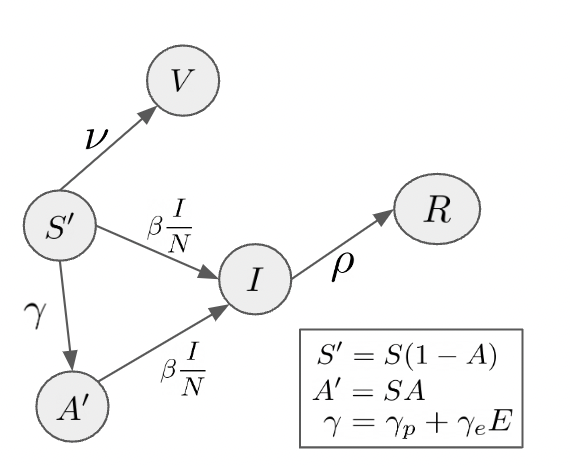

Unrolling the differential equations backwards in time, we get this CGM:
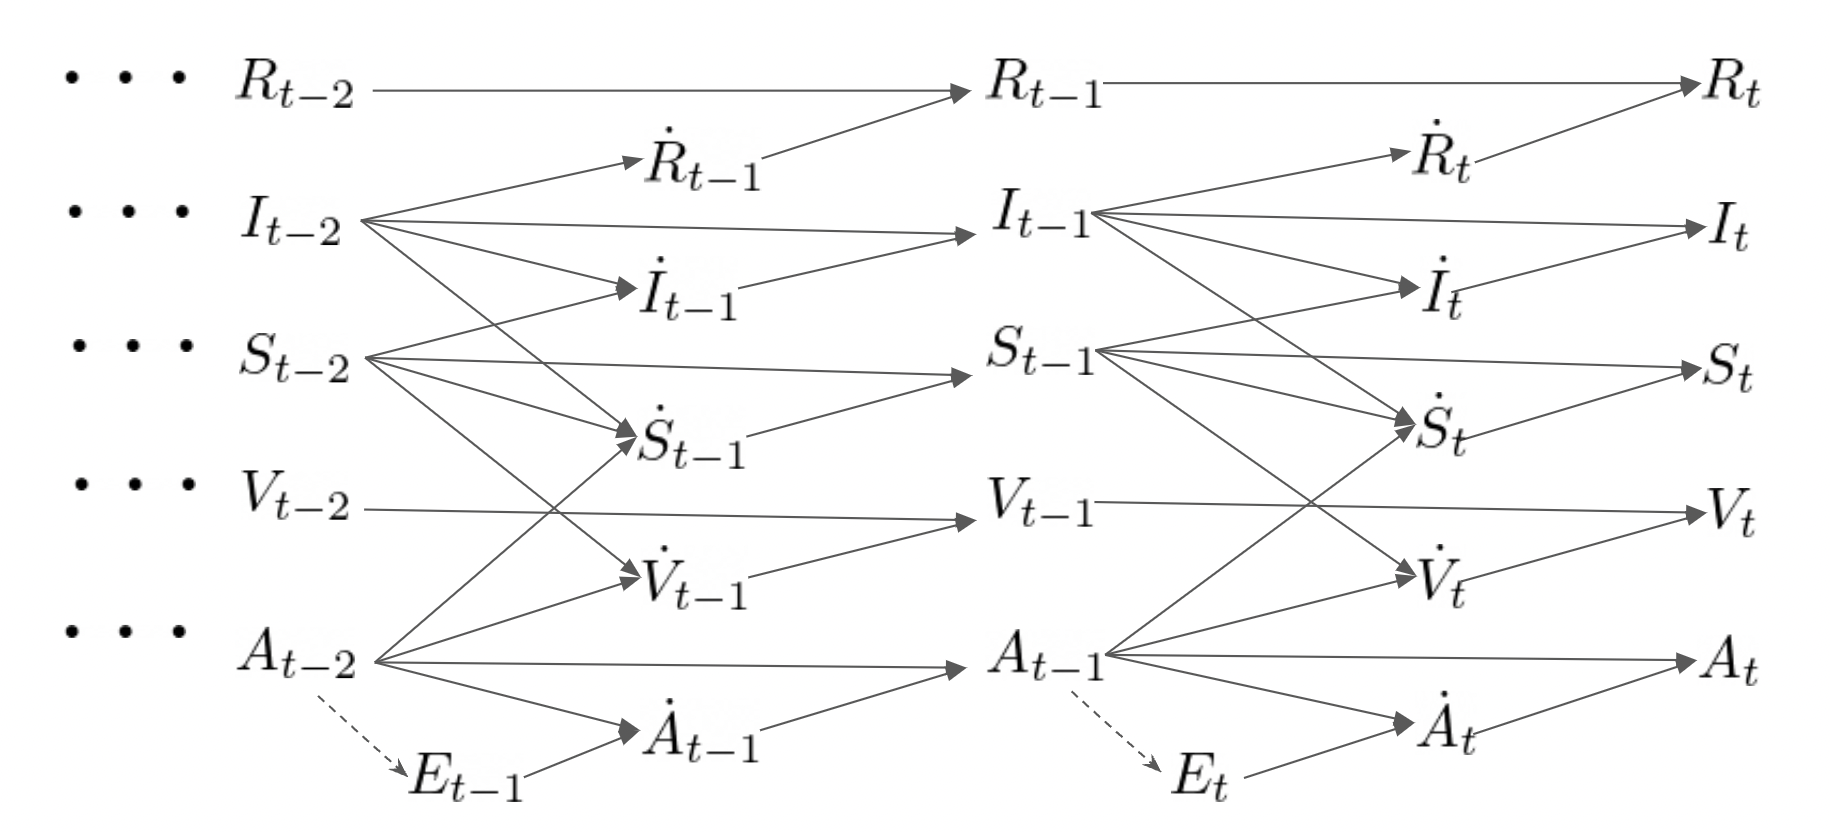
Below we create a networkx graph which contains this CGM, going backwards in time an arbitrary number of timesteps, nlags

In [10]:

nlags = 4

# functional_dependencies = {
#     #variables in terms of their derivatives
#     'S':['S_tlag1','S_dxdt1'],           # S = S_tlag + \int_{t-1}^t  S_dxdt dt
#     'I':['I_tlag1','I_dxdt1'],           # I = I_tlag + \int_{t-1}^t  I_dxdt dt
#     'R':['R_tlag1','R_dxdt1'],           # R = R_tlag + \int_{t-1}^t  R_dxdt dt
#     'V':['V_tlag1','V_dxdt1'],           # V = V_tlag + \int_{t-1}^t  V_dxdt dt
#     'D':['D_tlag1','D_dxdt1'],           # D = D_tlag + \int_{t-1}^t  D_dxdt dt
#     'A':['A_tlag1','A_dxdt1'],           # A = A_tlag + \int_{t-1}^t  D_dxdt dt = A_0 + \int_{tau<=t}(A_dxdt(tau))
    
#     #features derived from variables. 
#     '(1-A)':['A', 'const'], #include this feature so we can easily get the S*(1-A) feature during the estimation step below
    
#     #differential equation model
#     'S_dxdt1':['S_tlag1','I_tlag1','(1-A)_tlag1'],      # S_dxdt = -beta*(I)*S - nu*S*(1-A)
#     'I_dxdt1':['I_tlag1','S_tlag1'],                    # I_dxdt = beta*(I)*S - rho*I
#     'R_dxdt1':['I_tlag1'],                              # R_dxdt = rho*I
#     'V_dxdt1':['S_tlag1', '(1-A)_tlag1'],               # V_dxdt = nu*(S*(1-A))
#     'D_dxdt1':['I_tlag1'],                              # D_dxdt = phi*rho*I
#     'A_dxdt1':['E_dxdt8','(1-A)_tlag1','A_tlag1'],      # A_dxdt = (gamma_p + gamma_e * E_a_dxdt8 + gamma_a * A) * (1-A)
    
#     #confounders on exposures
#     'E_dxdt8':['A_tlag1'],                          

# }

functional_dependencies = {
    #variables in terms of their derivatives
    'S':['S_tlag1','S_dxdt1_tlag1'],           # S = S_tlag + \int_{t-1}^t  S_dxdt dt
    'I':['I_tlag1','I_dxdt1_tlag1'],           # I = I_tlag + \int_{t-1}^t  I_dxdt dt
    'R':['R_tlag1','R_dxdt1_tlag1'],           # R = R_tlag + \int_{t-1}^t  R_dxdt dt
    'V':['V_tlag1','V_dxdt1_tlag1'],           # V = V_tlag + \int_{t-1}^t  V_dxdt dt
    'D':['D_tlag1','D_dxdt1_tlag1'],           # D = D_tlag + \int_{t-1}^t  D_dxdt dt
    'A':['A_tlag1','A_dxdt1_tlag1'],           # A = A_tlag + \int_{t-1}^t  D_dxdt dt = A_0 + \int_{tau<=t}(A_dxdt(tau))
    
    #features derived from variables. 
    '(1-A)':['A', 'const'], #include this feature so we can easily get the S*(1-A) feature during the estimation step below
    
    #differential equation model
    'S_dxdt1':['S','I','(1-A)','E_dxdt8'],      # S_dxdt = -beta*(I)*S - nu*S*(1-A)
    'I_dxdt1':['I','S'],                        # I_dxdt = beta*(I)*S - rho*I
    'R_dxdt1':['I'],                            # R_dxdt = rho*I
    'V_dxdt1':['S', '(1-A)'],                   # V_dxdt = nu*(S*(1-A))
    'D_dxdt1':['I'],                            # D_dxdt = phi*rho*I
    'A_dxdt1':['E_dxdt8','(1-A)'],              # A_dxdt = (gamma_p + gamma_e * E_a_dxdt8) * (1-A)
    
    #confounders on exposures
    'E_dxdt8':['A'],                          

}

def lag_this_name(name):
    dont_lags = ['A_0', 'const']
    if name not in dont_lags:
        if '_tlag' in name:
            lag = int(name[-1])
            name = name[:-1]+str(lag+1)
        else:
            name = name+'_tlag1'
    return name

def add_lag_to_dependencies(adjlist):
    for k in list(adjlist.keys()):
        adjlist[lag_this_name(k)] = [lag_this_name(v) for v in adjlist[k]]
    return adjlist

def replace_maxlag_A_with_A0(adjlist): #assumes adjlist is sorted by lag, ascending
    A_maxlag = [k for k in adjlist.keys() if ((k=='A') or ('A_tlag' in k))][-1]
    A_dxdt_maxlag = [k for k in adjlist.keys() if 'A_dxdt' in k][-1]
    maxlax = 0 if A_maxlag=='A' else A_maxlag[-1]
    adjlist[A_maxlag] = ['A_0', 'A_dxdt_tlag'+str(maxlax)]
    adjlist[A_dxdt_maxlag] = ['E_tlag'+str(maxlax), 'A_0']
    return adjlist

def adjlist_to_edgelist(adjlist):
    edgelist = list()
    for k in list(adjlist.keys()):
        edgelist+=[(v, k) for v in adjlist[k]]
    return edgelist

def adjlist_to_nodelist(adjlist):
    nodelist = list()
    for k in list(adjlist.keys()):
        nodelist += [k] + adjlist[k]
    nodelist = list(dict([(i, 1) for i in nodelist]).keys())
    return nodelist


for lag in range(nlags):
    functional_dependencies = add_lag_to_dependencies(functional_dependencies)
    
functional_dependencies = replace_maxlag_A_with_A0(functional_dependencies) #adds basecase for latent var A
edgelist = adjlist_to_edgelist(functional_dependencies)
nodelist = adjlist_to_nodelist(functional_dependencies)

In [11]:
functional_dependencies

{'S': ['S_tlag1', 'S_dxdt1_tlag1'],
 'I': ['I_tlag1', 'I_dxdt1_tlag1'],
 'R': ['R_tlag1', 'R_dxdt1_tlag1'],
 'V': ['V_tlag1', 'V_dxdt1_tlag1'],
 'D': ['D_tlag1', 'D_dxdt1_tlag1'],
 'A': ['A_tlag1', 'A_dxdt1_tlag1'],
 '(1-A)': ['A', 'const'],
 'S_dxdt1': ['S', 'I', '(1-A)', 'E_dxdt8'],
 'I_dxdt1': ['I', 'S'],
 'R_dxdt1': ['I'],
 'V_dxdt1': ['S', '(1-A)'],
 'D_dxdt1': ['I'],
 'A_dxdt1': ['E_dxdt8', '(1-A)'],
 'E_dxdt8': ['A'],
 'S_tlag1': ['S_tlag2', 'S_dxdt1_tlag2'],
 'I_tlag1': ['I_tlag2', 'I_dxdt1_tlag2'],
 'R_tlag1': ['R_tlag2', 'R_dxdt1_tlag2'],
 'V_tlag1': ['V_tlag2', 'V_dxdt1_tlag2'],
 'D_tlag1': ['D_tlag2', 'D_dxdt1_tlag2'],
 'A_tlag1': ['A_tlag2', 'A_dxdt1_tlag2'],
 '(1-A)_tlag1': ['A_tlag1', 'const'],
 'S_dxdt1_tlag1': ['S_tlag1', 'I_tlag1', '(1-A)_tlag1', 'E_dxdt8_tlag1'],
 'I_dxdt1_tlag1': ['I_tlag1', 'S_tlag1'],
 'R_dxdt1_tlag1': ['I_tlag1'],
 'V_dxdt1_tlag1': ['S_tlag1', '(1-A)_tlag1'],
 'D_dxdt1_tlag1': ['I_tlag1'],
 'A_dxdt1_tlag1': ['E_dxdt8_tlag1', '(1-A)_tlag1'],
 'E_d

# 2. find generic causal estimand from causal graph

In [12]:
#define model object for  E_a_dxdt -> V
G = nx.DiGraph()
G.add_nodes_from(nodelist)
G.add_edges_from(edgelist)
G = ''.join(list(nx.generate_gml(G)))
model = CausalModel(
        data = data,
        treatment='E_dxdt8_tlag1',
        outcome='V_dxdt1',
        graph=G
        )

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                            
────────────────(E[V_dxdt1|A_tlag1])
d[E_dxdt8_tlag1]                    
Estimand assumption 1, Unconfoundedness: If U→{E_dxdt8_tlag1} and U→V_dxdt1 then P(V_dxdt1|E_dxdt8_tlag1,A_tlag1,U) = P(V_dxdt1|E_dxdt8_tlag1,A_tlag1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!




\begin{align}
\text{ATE}=\frac{d}{dE_{t-1}} \Big( \mathbb{E}[\dot{V}|\alpha_{t-1}] \Big)
\end{align}


# 3. compute causal estimand

### 3a. analytical solution

   $\text{ATE} = \frac{d}{dE_{t-1}} \Big(\mathbb{E}[\dot{V_t} \mid \alpha_{t-1}]\Big) \approx -\frac{1}{(n_t-1) n_i n_s (\sum_i N_i)} \sum_{t=1}^{n_t} \sum_i \sum_s N_i \nu_s S_{t-1,i} \gamma_{e,s} (1-\alpha_{t-1, i,s}) = - \mathbb{E} \Big[\nu S_{t-1} \gamma_{e} (1-\alpha_{t-1}) \Big]$

   $ \Delta V_{t,i} = \Big(\text{ATE}\Big) E_{t-1, i} $

   $ \Delta V = \sum_{t,i} \Delta V_{t,i}$


   for counties i, times t, and posterior samples s.

In [13]:
def get_A_tlag1(A, A_tlag8): #linearly interpolates between A and A_tlag8 to get A_tlag1
    A_tlag1 = A - ((A - A_tlag8)*(1/8))
    return A_tlag1

def get_causal_posterior_df(data, posteriors):
    n_chains = len(posteriors.chain)
    n_draws = len(posteriors.draw)
    df = list()
    for chain in range(n_chains):
        for draw in range(n_draws):

            #Get A_tlag1 by linearly interpolating between known datapoints 
            A_tlag8 = posteriors['A'][chain, draw,-(len(data)+n_fips):-n_fips].to_numpy()
            A = posteriors['A'][chain, draw,-len(data):].to_numpy()
            A_tlag1 = get_A_tlag1(A, A_tlag8) 

            #unpack other posteriors
            nu = (posteriors['nu'][chain, draw, :].to_numpy() * np.ones((6*n_fips, 4))).T.ravel()[-len(data):] #checked
            gamma_e = float(posteriors['gamma_e'][chain, draw].to_numpy())

            #unpack data
            S_tlag1 = (data['S_tlag1']*data['N']).values
            E_tlag1 = data['E_dxdt8_tlag1'].values
            N = data['N'].values

            #get indicies
            t = data['t'].values
            county = data['FIPS'].values
            sample = chain*n_draws + draw #which posterior sample are we looking at?

            for j in range(len(S_tlag1)): #package into data table list
                df.append((A_tlag1[j],nu[j],gamma_e,S_tlag1[j],E_tlag1[j],t[j],county[j],sample,N[j]))

    df = pd.DataFrame(df, columns = ['A_tlag1','nu','gamma_e','S_tlag1','E_tlag1','t','i','s','N']) #list to df
    return df

In [14]:
df_causal = get_causal_posterior_df(data, posteriors)

In [15]:
df_causal

,A_tlag1,nu,gamma_e,S_tlag1,E_tlag1,t,i,s,N
0,0.7,0.0054,0.18,5.4e+08,0.0028,52,1005,0,24589
1,0.12,0.0054,0.18,5.3e+08,0.0024,60,1005,0,24589
2,0.37,0.0054,0.18,5.2e+08,0.0039,68,1005,0,24589
3,0.2,0.0054,0.18,5.1e+08,0.0055,76,1005,0,24589
4,0.61,0.0054,0.18,5e+08,0.004,84,1005,0,24589
...,...,...,...,...,...,...,...,...,...
39599995,0.86,0.008,0.2,3.8e+09,0.001,188,56025,4499,80815
39599996,0.8,0.008,0.2,3.8e+09,0.0018,196,56025,4499,80815
39599997,0.83,0.008,0.2,3.8e+09,0.0029,204,56025,4499,80815
39599998,0.73,0.008,0.2,3.8e+09,0.0032,212,56025,4499,80815


In [16]:
def compute_one_sample_ATE_and_DeltaV(df): #TODO: ensure this matches the paper's derivation or vice versa

    assert df['s'].nunique()==1 #calculation only valid for one sample at a time
    
    #compute ATE
    df['ATE_term'] = - (df['nu'] * df['S_tlag1'] * df['gamma_e'] * (1 - df['A_tlag1'])) / df['N']
    ATE = np.average(df['ATE_term'], weights = df['N'])

    #get mean Delta V for this sample of counties, and compute total delta V for whole population over whole timeseries.
    df['delta_V'] =  ATE * df['E_tlag1']
    delta_V_per_capita_per_day = np.average(df['delta_V']/df['N'], weights = df['N'])
    delta_V = delta_V_per_capita_per_day*337000000*24*8 #population 337 million, 24 timesteps in timeseries, 8 days per timestep.

    return delta_V, ATE

def compute_ATE_and_DeltaV_distribution(df):

    ATEs = list()
    delta_Vs = list()
    for s in df['s'].unique():
        sample_df = df[df['s']==s]
        delta_V, ATE = compute_one_sample_ATE_and_DeltaV(sample_df)
        delta_Vs.append(delta_V)
        ATEs.append(ATE)

    return pd.Series(delta_Vs), pd.Series(ATEs)

In [17]:
delta_Vs, ATEs = compute_ATE_and_DeltaV_distribution(df_causal) #posterior
delta_V, ATE = delta_Vs.mean(), ATEs.mean() #posterior means

In [18]:
print('causal estimand:', ATE)
print('cumulative impact on V (% of pop):', 100*delta_V/337000000) # approx 337 million people in US in 2021
print('cumulative impact on V (# of vaccinations):', delta_V)

causal estimand: -216.4233679329433
cumulative impact on V (% of pop): -0.08460461165997762
cumulative impact on V (# of vaccinations): -285117.5412941246


In [20]:
df_causal['E_tlag1'].median()

In [21]:
df_causal['E_tlag1'].sem()

ATE bounds 
mean: -216.4233679329433 
CI: (-257.37549357987115, -175.18496120117132) 
p: 0.00022217285047767163

delta V bounds 
mean: -285117.5412941246 
CI: (-339068.1358474718, -230789.7981924973) 
p: 0.00022217285047767163


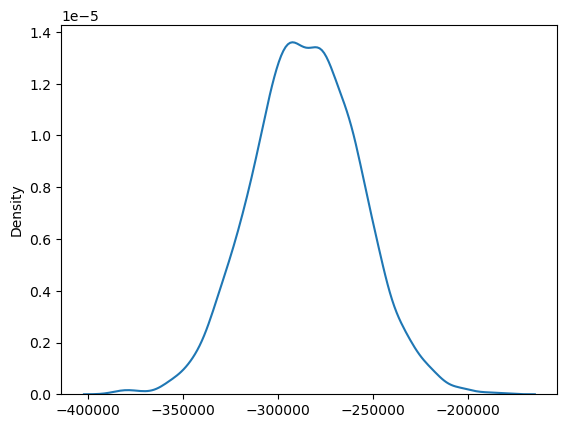

In [22]:
print('ATE bounds',
      '\nmean:', ATEs.mean(), 
      '\nCI:', (ATEs.quantile(0.025), 
              ATEs.quantile(0.975)
             ),
      '\np:', ((ATEs>=0).sum()+1)/(ATEs.count()+1)
     )
print()
print('delta V bounds',
      '\nmean:', delta_Vs.mean(), 
      '\nCI:', (delta_Vs.quantile(0.025), 
              delta_Vs.quantile(0.975)
             ),
      '\np:', ((delta_Vs>=0).sum()+1)/(delta_Vs.count()+1)
     )
sns.kdeplot(delta_Vs.sample(min(4000, len(delta_Vs))))
plt.show()

# 4. attempt to refute causal estimate

Look for confounder by looking for factors which may predict both $E$ and $\dot{V}$.  If factor $X$ predicts $E$, then either: the retweet network $W$ would show homophily in $X$, or it would predict both $T_j$ and $\dot{V}_i$ for county $i$ and its neighbors $j$. We can test common confounders and known model quantities for these properties.   

Overall, we find that $A$ is a confounder, and a set of common demographic/socioeconomic factors are not. 

### check if retweet network shows homophily in A_0 or A_final or antivax tweet production rate (T_a)

Mild homophily in the log-retweet network is detected.  This implies there may be a confounding influence from A->E, because antivaccine populations self-select to see more antivaccine content.  We should therefore add the A->E link to the CGM (as is done above).

In [23]:
#load MCMC posteriors
def SIRVAD_model(df, null=False): #dummy function to allow me to load the pickle below.
    return
with open(mcmc_pickle_filepath, "rb") as f:
    posteriors = az.from_numpyro(pickle.load(f))['posterior'] 

In [24]:
#load network and pad with zeros
network_sparse = pd.read_parquet('raw_retweet_neighbor_edgelist.parquet')
network = pd.DataFrame([(a,b) 
                             for a in network_sparse['retweeting_FIPS'].unique() 
                             for b in network_sparse['retweeted_FIPS'].unique()], 
                            columns = ['retweeting_FIPS','retweeted_FIPS'])
network = network.merge(network_sparse, on= ['retweeting_FIPS','retweeted_FIPS'], how='left').fillna(0)
network['n_retweets'] = network['n_retweets'].astype(int)

#load A_df
A_df = pd.read_parquet(mcmc_data_filepath)[['date','FIPS']].sort_values(['FIPS','date'])
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.groupby('FIPS').agg('first').drop(columns='date').reset_index().rename(columns={'A':'A_0'})
 
#merge A onto network
network = network.merge(A_df.rename(columns={'A_0':'retweeting_A_0'}), 
                        left_on= 'retweeting_FIPS', right_on='FIPS', how='inner').drop(columns='FIPS')
network = network.merge(A_df.rename(columns={'A_0':'retweeted_A_0'}), 
                        left_on= 'retweeted_FIPS',right_on='FIPS', how='inner').drop(columns='FIPS')
network['A_0_absdist'] = (network['retweeted_A_0'] - network['retweeting_A_0']).abs()

#load T_a_df
T_a_df = pd.read_parquet('time_series_df.parquet').sort_values(['FIPS','date'])[['FIPS','date','cumulative_antivax_tweets', 'population']]
T_a_df = T_a_df.groupby('FIPS').agg('last').drop(columns='date').reset_index()
T_a_df['T_a'] = T_a_df['cumulative_antivax_tweets']/ T_a_df['population']
T_a_df = T_a_df[['FIPS','T_a']]

#load A_df
A_df = pd.read_parquet(mcmc_data_filepath)[['date','FIPS']].sort_values(['FIPS','date'])
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.groupby('FIPS').agg('last').drop(columns='date').reset_index().rename(columns={'A':'A_final'})
 
#merge A onto network
network = network.merge(A_df.rename(columns={'A_final':'retweeting_A_final'}), 
                        left_on= 'retweeting_FIPS', right_on='FIPS', how='inner').drop(columns='FIPS')
network = network.merge(A_df.rename(columns={'A_final':'retweeted_A_final'}), 
                        left_on= 'retweeted_FIPS',right_on='FIPS', how='inner').drop(columns='FIPS')
network['A_final_absdist'] = (network['retweeted_A_final'] - network['retweeting_A_final']).abs()

#merge A onto network
network = network.merge(T_a_df.rename(columns={'T_a':'retweeting_T_a'}), 
                        left_on= 'retweeting_FIPS', right_on='FIPS', how='inner').drop(columns='FIPS')
network = network.merge(T_a_df.rename(columns={'T_a':'retweeted_T_a'}), 
                        left_on= 'retweeted_FIPS',right_on='FIPS', how='inner').drop(columns='FIPS')
network['T_a_absdist'] = (network['retweeted_T_a'] - network['retweeting_T_a']).abs()

#check homophily by correlation
network['n_retweets_log'] = np.log(network['n_retweets'])
print(network[['n_retweets','A_0_absdist','A_final_absdist','T_a_absdist']].corr())
print(network[['n_retweets_log','A_0_absdist','A_final_absdist','T_a_absdist']].corr())



                 n_retweets  A_0_absdist  A_final_absdist  T_a_absdist
n_retweets                1       -0.015           -0.014     -0.00046
A_0_absdist          -0.015            1             0.29       0.0085
A_final_absdist      -0.014         0.29                1         0.04
T_a_absdist        -0.00046       0.0085             0.04            1
                 n_retweets_log  A_0_absdist  A_final_absdist  T_a_absdist
n_retweets_log                1       -0.089           -0.068        0.023
A_0_absdist              -0.089            1             0.29       0.0085
A_final_absdist          -0.068         0.29                1         0.04
T_a_absdist               0.023       0.0085             0.04            1


### test if A correlates to T
the correlation between A and T is small, indicating that if A is a confounder, it is likely weak. 

In [25]:
T_a_df = pd.read_parquet('time_series_df.parquet').sort_values(['FIPS','date'])[['FIPS','date','cumulative_antivax_tweets', 'population']]
T_a_df = T_a_df.groupby('FIPS').agg('last').drop(columns='date').reset_index()
T_a_df['T_a'] = T_a_df['cumulative_antivax_tweets']/ T_a_df['population']

#load A_df
A_df = pd.read_parquet(mcmc_data_filepath)[['date','FIPS']].sort_values(['FIPS','date'])
A_df['A'] = posteriors['A'].mean(dim=['chain','draw'])
A_df = A_df.groupby('FIPS').agg('last').drop(columns='date').reset_index()

df = A_df.merge(T_a_df, on=['FIPS'], how='inner')
df[['A', 'T_a']].corr()


,A,T_a
A,1,-0.064
T_a,-0.064,1


### check if retweet network shows homophily in demographic/socioeconomic confounders

Some homophily found. demographics might be confounders, if they predict $\dot{V}$

In [26]:
#load network and pad with zeros
network_sparse = pd.read_parquet('raw_retweet_neighbor_edgelist.parquet')
network = pd.DataFrame([(a,b) 
                             for a in network_sparse['retweeting_FIPS'].unique() 
                             for b in network_sparse['retweeted_FIPS'].unique()], 
                            columns = ['retweeting_FIPS','retweeted_FIPS'])
network = network.merge(network_sparse, on= ['retweeting_FIPS','retweeted_FIPS'], how='left').fillna(0)
network['n_retweets'] = network['n_retweets'].astype(int)
network['n_retweets_log'] = np.log(network['n_retweets'])

#load confounders df
confounders_df = pd.read_parquet('time_series_df.parquet'
                                ).sort_values(by=['date','FIPS']
                                ).groupby('FIPS').agg('last'
                                ).reset_index(
                                )[['FIPS']+confounders]

#merge A onto network
for confounder in confounders:
    network = network.merge(confounders_df.rename(columns={confounder:'retweeting_'+confounder}), 
                            left_on= 'retweeting_FIPS', right_on='FIPS', how='inner').drop(columns='FIPS')
    network = network.merge(confounders_df.rename(columns={confounder:'retweeted_'+confounder}), 
                            left_on= 'retweeted_FIPS',right_on='FIPS', how='inner').drop(columns='FIPS')
    network[confounder+'_absdist'] = (network['retweeted_'+confounder] - network['retweeting_'+confounder]).abs()
    print(network[[ confounder+'_absdist', 'n_retweets', 'n_retweets_log']].corr()[confounder+'_absdist'])
    
    

RepublicanPct2020_absdist         1
n_retweets                  -0.0063
n_retweets_log                -0.06
Name: RepublicanPct2020_absdist, dtype: float64
RUCC_2013_absdist        1
n_retweets          -0.016
n_retweets_log        -0.2
Name: RUCC_2013_absdist, dtype: float64
Under18Pct2010_absdist          1
n_retweets               -0.00097
n_retweets_log             -0.022
Name: Under18Pct2010_absdist, dtype: float64
Age65AndOlderPct2010_absdist         1
n_retweets                     -0.0088
n_retweets_log                  -0.099
Name: Age65AndOlderPct2010_absdist, dtype: float64
Ed5CollegePlusPct_absdist         1
n_retweets                  -0.0018
n_retweets_log               -0.045
Name: Ed5CollegePlusPct_absdist, dtype: float64
GiniCoeff_absdist       1
n_retweets          0.002
n_retweets_log      0.053
Name: GiniCoeff_absdist, dtype: float64
PopDensity2010_log_absdist         1
n_retweets                   -0.0018
n_retweets_log                -0.021
Name: PopDensity2010_lo

### check if demographic/socioeconomic confounders predict $\dot{V}$

demographic/socioeconomic features do not predict $\dot{V}$. we can rule them out as strong confounders.

In [27]:
from data_cleaning_tools import get_dxdts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

In [28]:
#load confounders df
confounders_df = pd.read_parquet('time_series_df.parquet').sort_values(['FIPS','date'])
res_df = pd.read_parquet(mcmc_data_filepath)
confounders_df['V'] = confounders_df['cumulative_vaccinations']/confounders_df['population']
confounders_df = get_dxdts(confounders_df, ['V'])[['FIPS','date','V_dxdt1']+confounders]
confounders_df = confounders_df[confounders_df['date'].isin(res_df['date'])]
confounders_df = confounders_df[confounders_df['FIPS'].isin(res_df['FIPS'])]
confounders_df[confounders] = StandardScaler().fit_transform(confounders_df[confounders].values)
confounders_df

,FIPS,date,V_dxdt1,RepublicanPct2020,RUCC_2013,Under18Pct2010,Age65AndOlderPct2010,Ed5CollegePlusPct,GiniCoeff,PopDensity2010_log,BlackNonHispanicPct2010_log,HispanicPct2010_log,AsianNonHispanicPct2010_log,MedHHInc_log,WhiteNonHispanicPct2010_neglog,n_tweets_all_time_per_capita_log
763,1005,2021-02-06,0.00077,-0.23,1,-0.48,-0.0093,-1.2,0.62,-0.9,1.5,0.12,-0.85,-1.8,-1.3,-1.5
771,1005,2021-02-14,0.00016,-0.23,1,-0.48,-0.0093,-1.2,0.62,-0.9,1.5,0.12,-0.85,-1.8,-1.3,-1.5
779,1005,2021-02-22,8.1e-05,-0.23,1,-0.48,-0.0093,-1.2,0.62,-0.9,1.5,0.12,-0.85,-1.8,-1.3,-1.5
787,1005,2021-03-02,0.0014,-0.23,1,-0.48,-0.0093,-1.2,0.62,-0.9,1.5,0.12,-0.85,-1.8,-1.3,-1.5
795,1005,2021-03-10,0.0023,-0.23,1,-0.48,-0.0093,-1.2,0.62,-0.9,1.5,0.12,-0.85,-1.8,-1.3,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128223,56025,2021-07-08,3.7e-05,0.87,-0.25,0.16,-0.52,-0.26,-0.45,-1.4,-0.94,0.44,-0.41,0.68,0.47,0.26
1128231,56025,2021-07-16,0.00068,0.87,-0.25,0.16,-0.52,-0.26,-0.45,-1.4,-0.94,0.44,-0.41,0.68,0.47,0.26
1128239,56025,2021-07-24,0.00067,0.87,-0.25,0.16,-0.52,-0.26,-0.45,-1.4,-0.94,0.44,-0.41,0.68,0.47,0.26
1128247,56025,2021-08-01,2.5e-05,0.87,-0.25,0.16,-0.52,-0.26,-0.45,-1.4,-0.94,0.44,-0.41,0.68,0.47,0.26


In [29]:
# raw correlations
confounders_df.corr()['V_dxdt1']

FIPS                                 0.026
V_dxdt1                                  1
RepublicanPct2020                   -0.096
RUCC_2013                           -0.058
Under18Pct2010                      0.0034
Age65AndOlderPct2010               -0.0096
Ed5CollegePlusPct                      0.1
GiniCoeff                           -0.013
PopDensity2010_log                   0.042
BlackNonHispanicPct2010_log         -0.041
HispanicPct2010_log                  0.032
AsianNonHispanicPct2010_log           0.09
MedHHInc_log                           0.1
WhiteNonHispanicPct2010_neglog      0.0093
n_tweets_all_time_per_capita_log     0.053
Name: V_dxdt1, dtype: float64

In [30]:
#linear regression prediction from confounders to V_dxdt. LOW explained variance -> no strong predictors
from sklearn.linear_model import LinearRegression

res = list()
explained_variance = list()
for i in range(1000): #boostrap results for rough p values
    df1 = confounders_df.sample(frac=1, replace=True)
    features = confounders[:-1]
    X = df1[features].values
    y = df1['V_dxdt1'].values
    reg = LinearRegression().fit(y=y, X=X)
    res.append(reg.coef_)
    explained_variance.append(explained_variance_score(y_true=y, y_pred=reg.predict(X)))

#compute mean explained variance
explained_variance = pd.Series(explained_variance)
explained_variance_lower = explained_variance.quantile(0.025)
explained_variance_upper = explained_variance.quantile(0.975)
explained_variance_mean = explained_variance.mean()
print('explained variance:',explained_variance_mean, '+/-', 
      max(explained_variance_mean-explained_variance_lower, explained_variance_upper-explained_variance_mean))

#clean up regression coefficient results into table
res = list(np.array(res).T)
res_summary = list()
for i,feature_res in enumerate(res):
    feature_res=pd.Series(feature_res)
    mean = feature_res.mean()
    lower = feature_res.quantile(0.025)
    upper = feature_res.quantile(0.975)
    if mean>0:  p = ((feature_res<=0).sum()+1)/(feature_res.count()+1) 
    else: p = ((feature_res>=0).sum()+1)/(feature_res.count()+1)
    res_summary.append((features[i],"%.5f" % mean,"%.3f" % p,("%.5f" % lower, "%.5f" % upper)))
res_summary = pd.DataFrame(res_summary,columns=['feature','coeff','p','95% CI'])
res_summary = res_summary.sort_values(['p','coeff'], ascending=[True,False])
print(res_summary)

explained variance: 0.025628019169150813 +/- 0.007128059672393862
                           feature     coeff      p                95% CI
3             Age65AndOlderPct2010   0.00021  0.001    (0.00012, 0.00029)
0                RepublicanPct2020  -0.00040  0.001  (-0.00051, -0.00029)
6               PopDensity2010_log  -0.00019  0.001  (-0.00031, -0.00007)
2                   Under18Pct2010   0.00015  0.002    (0.00006, 0.00022)
9      AsianNonHispanicPct2010_log   0.00017  0.005    (0.00005, 0.00028)
10                    MedHHInc_log   0.00017  0.009    (0.00004, 0.00031)
11  WhiteNonHispanicPct2010_neglog   0.00020  0.055   (-0.00005, 0.00044)
1                        RUCC_2013  -0.00007  0.077   (-0.00016, 0.00002)
5                        GiniCoeff   0.00003  0.224   (-0.00006, 0.00013)
4                Ed5CollegePlusPct   0.00002  0.392   (-0.00012, 0.00016)
7      BlackNonHispanicPct2010_log  -0.00002  0.426   (-0.00021, 0.00017)
8              HispanicPct2010_log  -0.00001  

In [31]:
#ML regression prediction from confounders to V_dxdt.LOW explained variance -> no strong predictors
from sklearn.ensemble import RandomForestRegressor

res = list()
explained_variance = list()
for i in range(100): #boostrap results for rough p values
    df1 = confounders_df.sample(frac=1, replace=True)
    features = confounders[:-1]
    X = df1[features].values
    y = df1['V_dxdt1'].values
    reg = RandomForestRegressor(max_depth=2).fit(y=y, X=X)
    res.append(reg.feature_importances_)
    explained_variance.append(explained_variance_score(y_true=y, y_pred=reg.predict(X)))

#compute mean explained variance
explained_variance = pd.Series(explained_variance)
explained_variance_lower = explained_variance.quantile(0.025)
explained_variance_upper = explained_variance.quantile(0.975)
explained_variance_mean = explained_variance.mean()
print('explained variance:',explained_variance_mean, '+/-', 
      max(explained_variance_mean-explained_variance_lower, explained_variance_upper-explained_variance_mean))

#clean up regression coefficient results into table
res = list(np.array(res).T)
res_summary = list()
for i,feature_res in enumerate(res):
    feature_res=pd.Series(feature_res)
    mean = feature_res.mean()
    lower = feature_res.quantile(0.025)
    upper = feature_res.quantile(0.975)
    res_summary.append((features[i],"%.3f" % mean,("%.3f" % lower, "%.3f" % upper)))
res_summary = pd.DataFrame(res_summary,columns=['feature','importance','95% CI'])
res_summary = res_summary.sort_values(['importance'], ascending=[False])
print(res_summary)

explained variance: 0.03153048244814183 +/- 0.006119720130471094
                           feature importance          95% CI
0                RepublicanPct2020      0.438  (0.215, 0.617)
7      BlackNonHispanicPct2010_log      0.197  (0.052, 0.344)
10                    MedHHInc_log      0.134  (0.010, 0.389)
4                Ed5CollegePlusPct      0.101  (0.001, 0.373)
6               PopDensity2010_log      0.042  (0.000, 0.136)
3             Age65AndOlderPct2010      0.038  (0.000, 0.167)
11  WhiteNonHispanicPct2010_neglog      0.016  (0.000, 0.058)
2                   Under18Pct2010      0.015  (0.000, 0.061)
5                        GiniCoeff      0.008  (0.000, 0.034)
9      AsianNonHispanicPct2010_log      0.007  (0.000, 0.038)
8              HispanicPct2010_log      0.003  (0.000, 0.015)
1                        RUCC_2013      0.001  (0.000, 0.007)
